In [90]:
pip install datasets pyvi tensorflow pandas numpy scikit-learn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [91]:
import os
import numpy as np
from pyvi import ViTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report

* Tải và đọc các file 



In [92]:
# Cấu trúc dữ liệu: (Tên tập dữ liệu, Path Sentences, Path Sentiments, Path Topics)
data_sets = [
    ("Train",
     r"D:\vscodepython\DS210_BTTH3\data\train-20251202T170431Z-1-001\train\sents.txt",
     r"D:\vscodepython\DS210_BTTH3\data\train-20251202T170431Z-1-001\train\sentiments.txt",
     r"D:\vscodepython\DS210_BTTH3\data\train-20251202T170431Z-1-001\train\topics.txt"),
     
    ("Dev",
     r"D:\vscodepython\DS210_BTTH3\data\dev-20251202T170511Z-1-001\dev\sents.txt",
     r"D:\vscodepython\DS210_BTTH3\data\dev-20251202T170511Z-1-001\dev\sentiments.txt",
     r"D:\vscodepython\DS210_BTTH3\data\dev-20251202T170511Z-1-001\dev\topics.txt"),
     
    ("Test",
     r"D:\vscodepython\DS210_BTTH3\data\test-20251202T170508Z-1-001\test\sents.txt",
     r"D:\vscodepython\DS210_BTTH3\data\test-20251202T170508Z-1-001\test\sentiments.txt",
     r"D:\vscodepython\DS210_BTTH3\data\test-20251202T170508Z-1-001\test\topics.txt")
]

# Dictionary để lưu trữ kết quả cuối cùng
loaded_data = {}

* Kiểm Tra Số Lượng 

In [93]:
import pandas as pd
from typing import List, Optional, Tuple

# Hàm helper để đọc file (Dựa trên code đã có)
def read_file_lines(file_path: str) -> Optional[List[str]]:
    """Hàm helper để đọc tất cả các dòng từ một file, loại bỏ ký tự xuống dòng."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            return [line.strip() for line in f if line.strip()] 
    except FileNotFoundError:
        print(f"Lỗi: Không tìm thấy file tại {file_path}")
        return None
    except Exception as e:
        print(f"Lỗi khi đọc file {file_path}: {e}")
        return None

# Dictionary để lưu trữ các DataFrame đã tải
all_dataframes = {}

# --- Vòng lặp Tải Dữ liệu và Tạo DataFrame (Dựa trên code của bạn) ---
for set_name, sents_path, sentiments_path, topics_path in data_sets:
    print(f"\n Đang Tải Dữ Liệu: {set_name.upper()} ")
    
    # 1. Đọc nội dung từ các file
    sentences = read_file_lines(sents_path)
    sentiments = read_file_lines(sentiments_path)
    topics = read_file_lines(topics_path)
    
    if sentences is None or sentiments is None or topics is None:
        print(f"Bỏ qua tập {set_name.upper()} do có lỗi đọc file.")
        continue
    
    # 2. Kiểm tra tính đồng nhất (Rất quan trọng!)
    if not (len(sentences) == len(sentiments) == len(topics)):
        print(f"CẢNH BÁO: Số lượng dòng không khớp trong tập {set_name.upper()}! Bỏ qua.")
        continue
        
    # Tạo DataFrame
    df = pd.DataFrame({
        'sentence': sentences,
        'sentiment': sentiments,
        'topic': topics
    })
    
    # Lưu trữ kết quả
    all_dataframes[set_name.lower()] = df
    print(f" Tải thành công {len(sentences)} mẫu dữ liệu và tạo DataFrame.")


 Đang Tải Dữ Liệu: TRAIN 
 Tải thành công 11426 mẫu dữ liệu và tạo DataFrame.

 Đang Tải Dữ Liệu: DEV 
 Tải thành công 1583 mẫu dữ liệu và tạo DataFrame.

 Đang Tải Dữ Liệu: TEST 
 Tải thành công 3166 mẫu dữ liệu và tạo DataFrame.


In [94]:


# Kết hợp tất cả các DataFrame (train, dev, test) thành một DataFrame duy nhất
if all_dataframes:
    try:
        combined_df = pd.concat(all_dataframes.values(), ignore_index=True)
        print(f"Đã tạo thành công combined_df với tổng số {len(combined_df)} mẫu.")
    except Exception as e:
        print(f"Lỗi khi kết hợp các DataFrame: {e}")
        combined_df = None
else:
    print("Không có DataFrame nào để kết hợp. Vui lòng kiểm tra lại quá trình tải file.")

Đã tạo thành công combined_df với tổng số 16175 mẫu.


## PHÂN TÍCH PHÂN BỐ NHÃN SENTIMENT (CẢM XÚC)

--- Thống kê nhãn tập TRAIN ---
           Count  Percentage (%)
sentiment                       
2           5643           49.39
0           5325           46.60
1            458            4.01


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\4015252959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, palette="viridis")



--- Thống kê nhãn tập DEV ---
           Count  Percentage (%)
sentiment                       
2            805           50.85
0            705           44.54
1             73            4.61

--- Thống kê nhãn tập TEST ---
           Count  Percentage (%)
sentiment                       
2           1590           50.22
0           1409           44.50
1            167            5.27


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\4015252959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, palette="viridis")
C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\4015252959.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, palette="viridis")


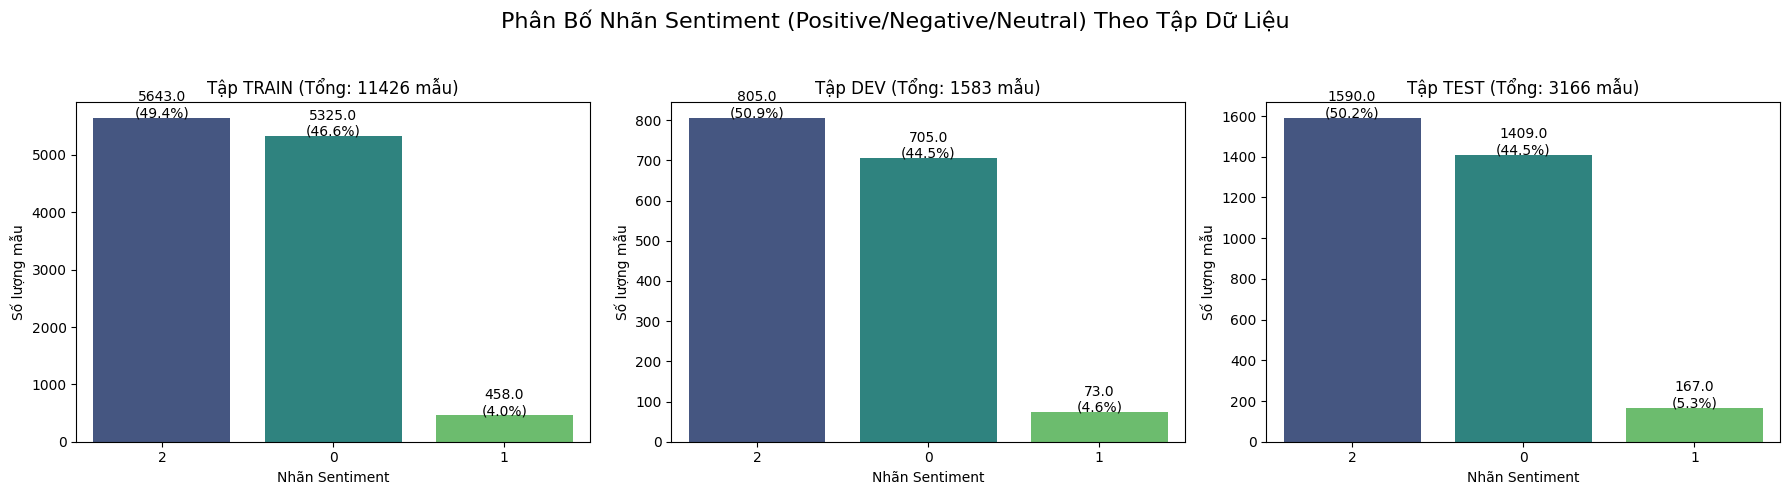

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
print("## PHÂN TÍCH PHÂN BỐ NHÃN SENTIMENT (CẢM XÚC)")
# Thiết lập figure cho các biểu đồ
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Phân Bố Nhãn Sentiment (Positive/Negative/Neutral) Theo Tập Dữ Liệu', fontsize=16)

# Lặp qua từng tập dữ liệu và vẽ biểu đồ
for i, (name, df) in enumerate(all_dataframes.items()):
    ax = axes[i]
    
    # Đếm số lần xuất hiện của từng nhãn
    label_counts = df['sentiment'].value_counts()
    
    # Tính phần trăm
    label_percentages = df['sentiment'].value_counts(normalize=True) * 100
    
    # In ra bảng thống kê
    print(f"\n--- Thống kê nhãn tập {name.upper()} ---")
    print(pd.DataFrame({
        'Count': label_counts,
        'Percentage (%)': label_percentages.round(2)
    }))
    
    # Vẽ biểu đồ Bar
    sns.barplot(x=label_counts.index, y=label_counts.values, ax=ax, palette="viridis")
    ax.set_title(f'Tập {name.upper()} (Tổng: {len(df)} mẫu)')
    ax.set_xlabel('Nhãn Sentiment')
    ax.set_ylabel('Số lượng mẫu')
    
    # Ghi chú giá trị trên mỗi cột
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height}\n({height/len(df):.1%})', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points')
plt.tight_layout(rect=[0, 0, 1, 0.95]) # Điều chỉnh layout để không đè lên suptitle
plt.show()

In [96]:

print("1. KIỂM TRA SỐ LƯỢNG VÀ TÊN CỘT")

# Lấy thông tin cột từ tập TRAIN (thường là chuẩn)
if 'train' in all_dataframes:
    train_df = all_dataframes['train']
    expected_cols = train_df.columns.tolist()
    print(f" Số lượng cột {len(expected_cols)}")
    print(f" Tên các cột: {expected_cols}")

1. KIỂM TRA SỐ LƯỢNG VÀ TÊN CỘT
 Số lượng cột 3
 Tên các cột: ['sentence', 'sentiment', 'topic']


In [97]:

print(" LẤY 10 MẪU ĐẦU TIÊN (Tập TRAIN)")


if 'train' in all_dataframes:
    train_df = all_dataframes['train']
    
    print(f"10 mẫu dữ liệu đầu tiên của tập TRAIN (Total: {len(train_df)}):")
    
    # In 10 mẫu đầu tiên
    print(train_df.head(10))
else:
    print("Lỗi: Không tìm thấy DataFrame 'train' để xem mẫu.")

 LẤY 10 MẪU ĐẦU TIÊN (Tập TRAIN)
10 mẫu dữ liệu đầu tiên của tập TRAIN (Total: 11426):
                                            sentence sentiment topic
0                          slide giáo trình đầy đủ .         2     1
1     nhiệt tình giảng dạy , gần gũi với sinh viên .         2     0
2               đi học đầy đủ full điểm chuyên cần .         0     1
3  chưa áp dụng công nghệ thông tin và các thiết ...         0     0
4  thầy giảng bài hay , có nhiều bài tập ví dụ ng...         2     0
5  giảng viên đảm bảo thời gian lên lớp , tích cự...         2     0
6  em sẽ nợ môn này , nhưng em sẽ học lại ở các h...         1     3
7  thời lượng học quá dài , không đảm bảo tiếp th...         0     1
8  nội dung môn học có phần thiếu trọng tâm , hầu...         0     1
9  cần nói rõ hơn bằng cách trình bày lên bảng th...         0     1


In [98]:
import pandas as pd

if 'train' in all_dataframes:
    train_df = all_dataframes['train']
    
    # Đếm số lần xuất hiện của từng nhãn
    sentiment_counts = train_df['sentiment'].value_counts()
    
    # Tính phần trăm tương ứng của từng nhãn
    sentiment_percentages = train_df['sentiment'].value_counts(normalize=True) * 100
    
    # Tạo DataFrame để hiển thị kết quả
    sentiment_distribution = pd.DataFrame({
        'Count': sentiment_counts,
        'Percentage (%)': sentiment_percentages.round(2)
    })
    
    print(f"Tổng số mẫu trong tập TRAIN: {len(train_df)}")
    print("\nBảng Thống kê Phân bố Nhãn SENTIMENT:")
    print(sentiment_distribution)
    
else:
    print("Lỗi: Không tìm thấy DataFrame cho tập 'train'.")

Tổng số mẫu trong tập TRAIN: 11426

Bảng Thống kê Phân bố Nhãn SENTIMENT:
           Count  Percentage (%)
sentiment                       
2           5643           49.39
0           5325           46.60
1            458            4.01


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\1988805568.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment', data=train_df, order=train_df['sentiment'].value_counts().index, palette="viridis")


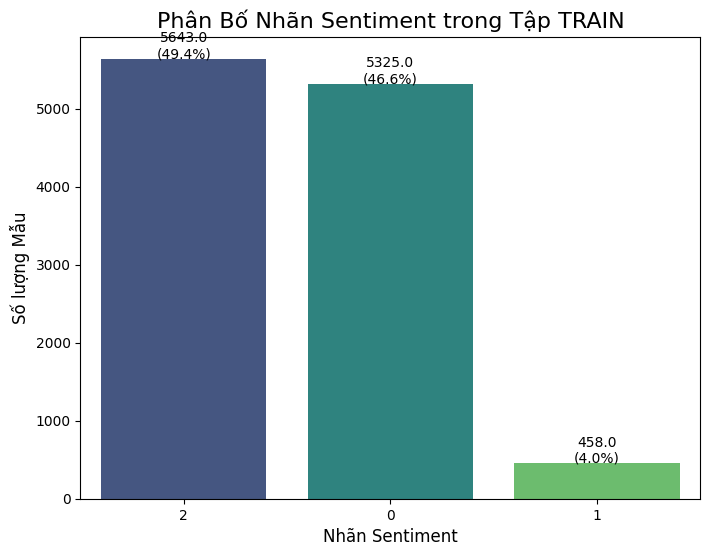

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'train' in all_dataframes:
    plt.figure(figsize=(8, 6))
    
    # Vẽ biểu đồ Bar Chart
    ax = sns.countplot(x='sentiment', data=train_df, order=train_df['sentiment'].value_counts().index, palette="viridis")
    
    # Tiêu đề và nhãn
    ax.set_title('Phân Bố Nhãn Sentiment trong Tập TRAIN', fontsize=16)
    ax.set_xlabel('Nhãn Sentiment', fontsize=12)
    ax.set_ylabel('Số lượng Mẫu', fontsize=12)
    
    # Thêm giá trị và phần trăm lên trên mỗi cột
    total = len(train_df)
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{height / total * 100:.1f}%'
        ax.annotate(f'{height}\n({percentage})', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontsize=10)
    
    plt.show()
    
else:
    print("Không thể vẽ biểu đồ vì không tìm thấy DataFrame 'train'.")

* DỮ Liệu Bị Lệch Nhãn Rất Nhiều 

In [100]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
print(" ĐẾM SỐ LƯỢNG TỪ VỰNG DUY NHẤT (UNIQUE TOKENS) ")


# **Lưu ý quan trọng:** Cần đảm bảo biến combined_df đã được định nghĩa và chứa dữ liệu.
if 'combined_df' not in locals() or combined_df is None:
    print("🚨 LỖI: Biến 'combined_df' chưa được định nghĩa hoặc đang trống. Vui lòng chạy lại cell Kết hợp Dữ liệu.")
else:
    # 1. Kết hợp tất cả câu văn thành một chuỗi lớn
    all_text = ' '.join(combined_df['sentence'].tolist())

    # 2. Tiền xử lý đơn giản: Đưa về chữ thường và loại bỏ các ký tự không phải chữ cái/số
    processed_text = all_text.lower()
    
    # Tách từ: Sử dụng Regex để tách các từ (chữ cái và số)
    tokens = re.findall(r'\b\w+\b', processed_text)
    
    # Đếm tổng số token
    total_tokens = len(tokens)
    
    # Đếm số lượng từ vựng duy nhất
    unique_tokens = set(tokens)
    num_unique_tokens = len(unique_tokens)

    print(f"Tổng số Tokens (từ) trong bộ dữ liệu: {total_tokens:,}")
    print(f"Tổng số Từ vựng Duy nhất (Unique Tokens): {num_unique_tokens:,}")
    
    # Tính tỷ lệ sự phong phú từ vựng (Type-Token Ratio)
    ttr = num_unique_tokens / total_tokens * 100
    print(f"Tỷ lệ Type-Token (TTR): {ttr:.2f}%")

 ĐẾM SỐ LƯỢNG TỪ VỰNG DUY NHẤT (UNIQUE TOKENS) 
Tổng số Tokens (từ) trong bộ dữ liệu: 203,815
Tổng số Từ vựng Duy nhất (Unique Tokens): 2,845
Tỷ lệ Type-Token (TTR): 1.40%


TOP 20 TỪ VỰNG XUẤT HIỆN NHIỀU NHẤT
Top 20 từ xuất hiện nhiều nhất (đã lowercase, chưa loại Stopwords):
- viên: 6,700 lần
- giảng: 5,239 lần
- dạy: 4,523 lần
- thầy: 4,409 lần
- sinh: 4,278 lần
- học: 4,114 lần
- bài: 3,309 lần
- tình: 3,211 lần
- không: 3,096 lần
- và: 2,904 lần
- có: 2,804 lần
- rất: 2,801 lần
- nhiệt: 2,761 lần
- hiểu: 2,427 lần
- cho: 2,416 lần
- nhiều: 2,283 lần
- dễ: 2,040 lần
- tập: 2,033 lần
- thực: 2,003 lần
- cô: 1,699 lần


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\4053844774.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="plasma")


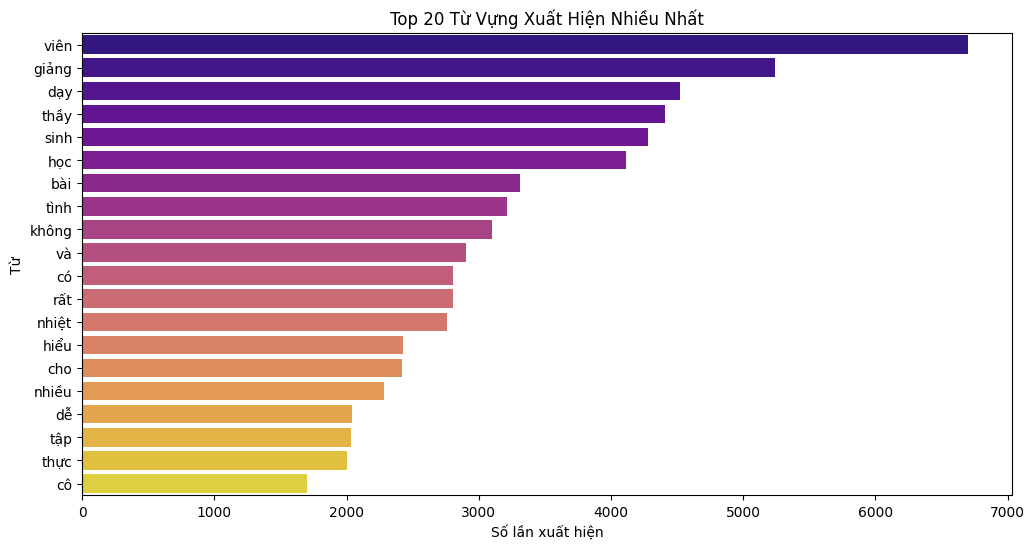

In [101]:

print("TOP 20 TỪ VỰNG XUẤT HIỆN NHIỀU NHẤT")

if 'tokens' in locals() and tokens:
    # Sử dụng Counter để đếm tần suất
    word_counts = Counter(tokens)
    
    # Lấy 20 từ xuất hiện nhiều nhất
    top_20_words = word_counts.most_common(20)

    print(f"Top 20 từ xuất hiện nhiều nhất (đã lowercase, chưa loại Stopwords):")
    for word, count in top_20_words:
        print(f"- {word}: {count:,} lần")
        
    # Vẽ biểu đồ Bar cho Top 20
    plt.figure(figsize=(12, 6))
    words, counts = zip(*top_20_words)
    sns.barplot(x=list(counts), y=list(words), palette="plasma")
    plt.title('Top 20 Từ Vựng Xuất Hiện Nhiều Nhất')
    plt.xlabel('Số lần xuất hiện')
    plt.ylabel('Từ')
    plt.show()
    
else:
    print("Không thể thống kê Top 20 vì danh sách tokens chưa được tạo.")

Chất lượng Token hóa kém: TTR thấp như vậy (chỉ 1.40%) gần như chắc chắn cho thấy các bước tiền xử lý cơ bản (như lowercase và tách từ) đã được thực hiện, nhưng TÁCH TỪ CHƯA CHUẨN hoặc CHƯA LOẠI BỎ STOPWORDS.

Lặp từ Stopwords: Hầu hết các token (200,000+) có thể là các từ dừng (Stopwords) như và, là, của, không và các ký tự đặc biệt, khiến cho số lượng từ duy nhất (2,845) trở nên quá nhỏ so với tổng số từ.

Thiếu Word Segmentation: Đây là nguyên nhân lớn nhất trong tiếng Việt. Nếu từ ghép như nhà hàng bị tách thành hai token riêng lẻ là nhà và hàng thì ngữ nghĩa bị mất, và TTR sẽ bị ảnh hưởng.
-> Cần tiền xử lý 

In [102]:

! pip install underthesea unidecode


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [103]:
# Danh sách Stopwords tiếng Việt cơ bản (Cần bổ sung tùy theo kết quả EDA)
VIETNAMESE_STOPWORDS = {
    'là', 'thì', 'mà', 'của', 'và', 'hay', 'như', 'cũng', 'có', 'không', 
    'sẽ', 'đã', 'vẫn', 'chỉ', 'còn', 'được', 'nữa', 'rồi', 'về', 'ở', 'từ',
    'quá', 'mình', 'đâu', 'các', 'cho', 'cùng', 'này', 'kia', 'họ', 'bị', 'với',
    'cái', 'chiếc', 'một', 'hai', 'ba', 'tôi', 'em', 'anh', 'chị', 'mấy', 'những'
}

def preprocess_text(text: str) -> str:
    """
    Pipeline tiền xử lý cho một câu tiếng Việt, phục vụ cho Bi-LSTM.
    """
    
    # 1. Lowercasing
    text = text.lower().strip()

    # 2. Xử lý Emoji & Ký tự Thừa
    # Thay thế nhanh Emoji bằng ký tự mô tả
    text = text.replace('😂', 'cười_lớn').replace('😭', 'khóc_lóc').replace('👍', 'tốt')
    text = text.replace('💔', 'tim_vỡ').replace('😡', 'giận_dữ').replace('🔥', 'nóng')
    
    # Loại bỏ các ký tự đặc biệt, chỉ giữ lại chữ, số và khoảng trắng (cho phép dấu gạch dưới sau segmentation)
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # 3. Tách từ (Word Segmentation) - SỬ DỤNG underthesea
    # format="text" giữ nguyên dấu gạch dưới cho từ ghép
    tokens_segmented = word_tokenize(text, format="text") 
    
    # 4. Loại bỏ Stopwords và lọc các token rỗng/số
    tokens = tokens_segmented.split()
    processed_tokens = [
        token for token in tokens 
        if token not in VIETNAMESE_STOPWORDS and token.isalpha()
    ]
    
    return ' '.join(processed_tokens)

print("Đã định nghĩa hàm preprocess_text.")

Đã định nghĩa hàm preprocess_text.


In [104]:
from underthesea import word_tokenize

print("ÁP DỤNG TIỀN XỬ LÝ VÀ CHIA TẬP")

if combined_df is not None:
    # 1. Áp dụng Preprocessing lên toàn bộ dữ liệu
    df_processed = combined_df.copy()
    print("Đang thực hiện Word Segmentation và Preprocessing...")
    df_processed['processed_sentence'] = df_processed['sentence'].apply(preprocess_text)
    print(" Hoàn tất tiền xử lý!")

    # 2. Tách lại các tập dữ liệu dựa trên kích thước gốc
    len_train = len(all_dataframes.get('train', []))
    len_dev = len(all_dataframes.get('dev', []))
    
    df_train_processed = df_processed.iloc[:len_train]
    df_dev_processed = df_processed.iloc[len_train : len_train + len_dev]
    df_test_processed = df_processed.iloc[len_train + len_dev :]

    # 3. Lấy X và Y cuối cùng (Văn bản đã xử lý và Nhãn gốc)
    X_train = df_train_processed['processed_sentence'].tolist()
    Y_train = df_train_processed['sentiment'].tolist()
    
    X_dev = df_dev_processed['processed_sentence'].tolist()
    Y_dev = df_dev_processed['sentiment'].tolist()
    
    X_test = df_test_processed['processed_sentence'].tolist()
    Y_test = df_test_processed['sentiment'].tolist()
    
    print("\n--- Minh họa Kết quả Tách tập ---")
    print(f"X_train[0] (sau xử lý): '{X_train[0]}'")
    print(f"Y_train[0] (nhãn gốc): {Y_train[0]}")
    print(f"Kích thước X_train: {len(X_train)}")
else:
    print("Không thể tiền xử lý. Dữ liệu gốc không được tải thành công.")

ÁP DỤNG TIỀN XỬ LÝ VÀ CHIA TẬP
Đang thực hiện Word Segmentation và Preprocessing...
 Hoàn tất tiền xử lý!

--- Minh họa Kết quả Tách tập ---
X_train[0] (sau xử lý): 'slide'
Y_train[0] (nhãn gốc): 2
Kích thước X_train: 11426


In [105]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
if 'X_train' in locals():
    print(" 1. MÃ HÓA NHÃN (LABEL ENCODING) ")

    label_encoder = LabelEncoder()
    all_labels = Y_train + Y_dev + Y_test
    label_encoder.fit(all_labels)

    Y_train_encoded = label_encoder.transform(Y_train)
    Y_dev_encoded = label_encoder.transform(Y_dev)
    Y_test_encoded = label_encoder.transform(Y_test)

    print(f"Mã hóa nhãn hoàn tất. Các lớp nhãn: {label_encoder.classes_}")
    print(f"Y_train đầu tiên: {Y_train[0]} -> {Y_train_encoded[0]}")

 1. MÃ HÓA NHÃN (LABEL ENCODING) 
Mã hóa nhãn hoàn tất. Các lớp nhãn: ['0' '1' '2']
Y_train đầu tiên: 2 -> 2


In [106]:
if 'X_train' in locals():
    print("2. TOKENIZATION VÀ PADDING (CHUẨN BỊ CHO BI-LSTM)")

    MAX_WORDS = 10000 
    MAX_LEN = 100     

    # 1. Khởi tạo Tokenizer
    tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<unk>") 

    # 2. Xây dựng từ điển CHỈ TRÊN tập TRAIN
    tokenizer.fit_on_texts(X_train)

    # 3. Chuyển đổi văn bản thành chuỗi số
    X_train_sequences = tokenizer.texts_to_sequences(X_train)
    X_dev_sequences = tokenizer.texts_to_sequences(X_dev)
    X_test_sequences = tokenizer.texts_to_sequences(X_test)

    # 4. Padding/Truncaing
    X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    X_dev_padded = pad_sequences(X_dev_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
    X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

    # 5. Thông tin cuối cùng
    VOCAB_SIZE = len(tokenizer.word_index) + 1 # +1 cho chỉ số 0 (padding)
    NUM_CLASSES = len(label_encoder.classes_)

    print(f"✅ Vector hóa hoàn tất.")
    print(f"   -> Kích thước từ điển (VOCAB_SIZE): {VOCAB_SIZE}")
    print(f"   -> Số lượng lớp nhãn (NUM_CLASSES): {NUM_CLASSES}")
    print(f"   -> Hình dạng X_train cuối cùng: {X_train_padded.shape}")

2. TOKENIZATION VÀ PADDING (CHUẨN BỊ CHO BI-LSTM)
✅ Vector hóa hoàn tất.
   -> Kích thước từ điển (VOCAB_SIZE): 1472
   -> Số lượng lớp nhãn (NUM_CLASSES): 3
   -> Hình dạng X_train cuối cùng: (11426, 100)


In [107]:
import re
from underthesea import word_tokenize
from unidecode import unidecode
from unicodedata import normalize

# --- Định nghĩa Hàm Demo Từng Bước ---

# Danh sách Stopwords tiếng Việt cơ bản (như đã dùng ở phần trước)
VIETNAMESE_STOPWORDS = {
    'là', 'thì', 'mà', 'của', 'và', 'hay', 'như', 'cũng', 'có', 'không', 
    'sẽ', 'đã', 'vẫn', 'chỉ', 'còn', 'được', 'nữa', 'rồi', 'về', 'ở', 'từ',
    'quá', 'mình', 'đâu', 'các', 'cho', 'cùng', 'này', 'kia', 'họ', 'bị', 'với',
    'cái', 'chiếc', 'một', 'hai', 'ba', 'tôi', 'em', 'anh', 'chị', 'mấy', 'những'
}

# Câu gốc minh họa
raw_text = "Quán ăn này Phục Vụ tệ quá!!! Giá CẮT CỔ luôn đó . Nhưng đồ ĂN ngon, tôi SẼ quay lại. Hoà Bình." 

print("MINH HỌA TỪNG BƯỚC TIỀN XỬ LÝ DỮ LIỆU ")

print(f"CÂU GỐC: '{raw_text}'\n")

# 1. Chuẩn hóa Unicode
# Mục đích: Đảm bảo các ký tự có dấu được mã hóa đồng nhất
text_step_1 = normalize('NFC', raw_text).strip()
print("1. Chuẩn hóa Unicode/Loại bỏ Ký tự Lỗi (NFKC):")
print(f"   -> BEFORE (chứa các lỗi tiềm ẩn): {raw_text}")
print(f"   -> AFTER (Dạng chuẩn hóa): {text_step_1}")
print("   * Thay đổi: Đảm bảo 'Hoà' được xử lý thành 'Hòa' (nếu có lỗi mã hóa)\n")


# 2. Lowercasing & Xử lý Emoji/Ký tự Thừa
# Mục đích: Giảm kích thước từ vựng và loại bỏ nhiễu
text_step_2 = text_step_1.lower()
text_step_2 = re.sub(r'!!!+', '!', text_step_2) # Loại bỏ ký tự lặp
text_step_2 = text_step_2.replace('', 'giận_dữ') # Xử lý emoji
text_step_2 = re.sub(r'[^\w\s]', ' ', text_step_2) # Loại bỏ Punctuation
print("2. Lowercasing & Xử lý Emoji/Ký tự Thừa:")
print(f"   -> BEFORE: {text_step_1}")
print(f"   -> AFTER: {text_step_2.strip()}")
print("   * Thay đổi: 'Phục Vụ' -> 'phục vụ', '' -> 'giận_dữ', loại bỏ dấu câu.\n")


# 3. Tách từ (Word Segmentation)
# Mục đích: Gắn kết các từ ghép (compound words) để bảo toàn ngữ nghĩa
tokens_step_3 = word_tokenize(text_step_2, format="text") 
print("3. Tách từ (Word Segmentation - BẮT BUỘC):")
print(f"   -> BEFORE (Tokens cơ bản): {text_step_2.strip().split()}")
print(f"   -> AFTER (Đã Segment): {tokens_step_3}")
print("   * Thay đổi: 'quán ăn' -> 'quán_ăn', 'phục vụ' -> 'phục_vụ', 'cắt cổ' -> 'cắt_cổ'. \n")


# 4. Loại bỏ Stopwords và Lọc
# Mục đích: Loại bỏ các từ chức năng không mang tính phân loại
tokens_step_4 = tokens_step_3.split()
final_tokens = [
    token for token in tokens_step_4 
    if token not in VIETNAMESE_STOPWORDS and token.isalpha()
]
final_text = ' '.join(final_tokens)
print("4. Loại bỏ Stopwords và Lọc:")
print(f"   -> BEFORE (Tokens đã Segment): {tokens_step_3.split()}")
print(f"   -> AFTER (Final Tokens): {final_tokens}")
print("   * Thay đổi: Các từ 'này', 'quá', 'luôn', 'đó', 'tôi', 'sẽ' đã bị loại bỏ.\n")


print(f"KẾT QUẢ CUỐI CÙNG SẴN SÀNG CHO BI-LSTM: '{final_text}'")


MINH HỌA TỪNG BƯỚC TIỀN XỬ LÝ DỮ LIỆU 
CÂU GỐC: 'Quán ăn này Phục Vụ tệ quá!!! Giá CẮT CỔ luôn đó . Nhưng đồ ĂN ngon, tôi SẼ quay lại. Hoà Bình.'

1. Chuẩn hóa Unicode/Loại bỏ Ký tự Lỗi (NFKC):
   -> BEFORE (chứa các lỗi tiềm ẩn): Quán ăn này Phục Vụ tệ quá!!! Giá CẮT CỔ luôn đó . Nhưng đồ ĂN ngon, tôi SẼ quay lại. Hoà Bình.
   -> AFTER (Dạng chuẩn hóa): Quán ăn này Phục Vụ tệ quá!!! Giá CẮT CỔ luôn đó . Nhưng đồ ĂN ngon, tôi SẼ quay lại. Hoà Bình.
   * Thay đổi: Đảm bảo 'Hoà' được xử lý thành 'Hòa' (nếu có lỗi mã hóa)

2. Lowercasing & Xử lý Emoji/Ký tự Thừa:
   -> BEFORE: Quán ăn này Phục Vụ tệ quá!!! Giá CẮT CỔ luôn đó . Nhưng đồ ĂN ngon, tôi SẼ quay lại. Hoà Bình.
   -> AFTER: giận_dữqgiận_dữugiận_dữágiận_dữngiận_dữ giận_dữăgiận_dữngiận_dữ giận_dữngiận_dữàgiận_dữygiận_dữ giận_dữpgiận_dữhgiận_dữụgiận_dữcgiận_dữ giận_dữvgiận_dữụgiận_dữ giận_dữtgiận_dữệgiận_dữ giận_dữqgiận_dữugiận_dữágiận_dữ giận_dữ giận_dữggiận_dữigiận_dữágiận_dữ giận_dữcgiận_dữắgiận_dữtgiận_dữ giận_dữcgiận_dữổgiận_d

In [108]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from collections import Counter


DATA_PATH = r"D:\vscodepython\DS210_BTTH3\data\PhoNER_COVID19\data\word"

# Danh sách các tệp .conll cần đọc
FILE_CONFIG = {
    'train': 'train_word.conll',
    'dev': 'dev_word.conll',
    'test': 'test_word.conll',
}

def read_conll_file(file_path):
    """Đọc tệp .conll, trích xuất tokens (cột 1) và labels (cột cuối)."""
    all_tokens = []
    all_labels = []
    current_tokens = []
    current_labels = []
    
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                line = line.strip()
                if line:
                    parts = line.split() 
                    if len(parts) >= 2:
                        current_tokens.append(parts[0])
                        current_labels.append(parts[-1])
                else:
                    if current_tokens:
                        all_tokens.append(current_tokens)
                        all_labels.append(current_labels)
                    current_tokens = []
                    current_labels = []
            
            if current_tokens:
                all_tokens.append(current_tokens)
                all_labels.append(current_labels)
                
        return all_tokens, all_labels
    except FileNotFoundError:
        print(f" LỖI: Không tìm thấy tệp tại {file_path}.")
        return [], []
    except Exception as e:
        print(f"LỖI khi đọc tệp {file_path}: {e}")
        return [], []

# --- Tải và Tổng hợp Dữ liệu ---
all_data = {}
stats_list = [] # List để lưu trữ thống kê chi tiết

for set_name, conll_file in FILE_CONFIG.items():
    conll_path = os.path.join(DATA_PATH, conll_file)
    tokens, labels = read_conll_file(conll_path)
    
    num_sentences = len(tokens)
    num_tokens = sum(len(s) for s in tokens)
    
    if tokens and labels and num_sentences == len(labels):
        all_data[set_name] = {'tokens': tokens, 'labels': labels}
        print(f"Tải thành công tập {set_name.upper()} ({num_sentences} câu).")
        stats_list.append({
            'Tập Dữ liệu': set_name.upper(),
            'Số lượng Câu': f'{num_sentences:,}',
            'Số lượng Tokens': f'{num_tokens:,}'
        })
    else:
        print(f"LỖI tải/dữ liệu không khớp cho tập {set_name.upper()}.")


# Hàm Tổng hợp thành DataFrame (không đổi)
def flatten_data_for_eda(tokens_list, labels_list, set_name):
    # ... (giữ nguyên logic)
    data = []
    for i, (tokens, labels) in enumerate(zip(tokens_list, labels_list)):
        for j, (token, label) in enumerate(zip(tokens, labels)):
            data.append({
                'set': set_name,
                'sentence_id': i,
                'token': token,
                'label': label,
                'sentence_len': len(tokens)
            })
    return pd.DataFrame(data)

# Tạo DataFrame tổng hợp
df_list = []
for set_name, data in all_data.items():
    df_list.append(flatten_data_for_eda(data['tokens'], data['labels'], set_name))

if df_list:
    df_combined = pd.concat(df_list, ignore_index=True)
    total_sentences = df_combined['sentence_id'].nunique()
    total_tokens = len(df_combined)
    
    print("\n=====================================================")
    print("## 1. TỔNG QUAN VÀ THỐNG KÊ CHI TIẾT WORD-LEVEL ##")
    print("=====================================================")
    print(f"**TỔNG CỘNG** số Câu: **{total_sentences:,}**")
    print(f"**TỔNG CỘNG** số Tokens: **{total_tokens:,}**")
    
    print("\n--- Số lượng Câu và Tokens mỗi tập ---")
    df_stats = pd.DataFrame(stats_list)
    print(df_stats.to_markdown(index=False)) # Hiển thị kết quả bằng bảng Markdown
else:
    df_combined = pd.DataFrame()
    print(" KHÔNG THỂ TIẾN HÀNH EDA: Không có dữ liệu nào được tải thành công.")

Tải thành công tập TRAIN (5027 câu).
Tải thành công tập DEV (2000 câu).
Tải thành công tập TEST (3000 câu).

## 1. TỔNG QUAN VÀ THỐNG KÊ CHI TIẾT WORD-LEVEL ##
**TỔNG CỘNG** số Câu: **5,027**
**TỔNG CỘNG** số Tokens: **274,472**

--- Số lượng Câu và Tokens mỗi tập ---
| Tập Dữ liệu   | Số lượng Câu   | Số lượng Tokens   |
|:--------------|:---------------|:------------------|
| TRAIN         | 5,027          | 132,511           |
| DEV           | 2,000          | 56,283            |
| TEST          | 3,000          | 85,678            |


In [109]:
df_combined.head(20)

,set,sentence_id,token,label,sentence_len
0,train,0,Đồng_thời,O,18
1,train,0,",",O,18
2,train,0,bệnh_viện,O,18
3,train,0,tiếp_tục,O,18
4,train,0,thực_hiện,O,18
5,train,0,các,O,18
6,train,0,biện_pháp,O,18
7,train,0,phòng_chống,O,18
8,train,0,dịch_bệnh,O,18
9,train,0,COVID,O,18


 2. PHÂN BỐ NHÃN THỰC THỂ 


C:\Users\AFMIN\AppData\Local\Temp\ipykernel_28072\2640524860.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=entity_labels.index, y=entity_labels.values, palette="viridis")


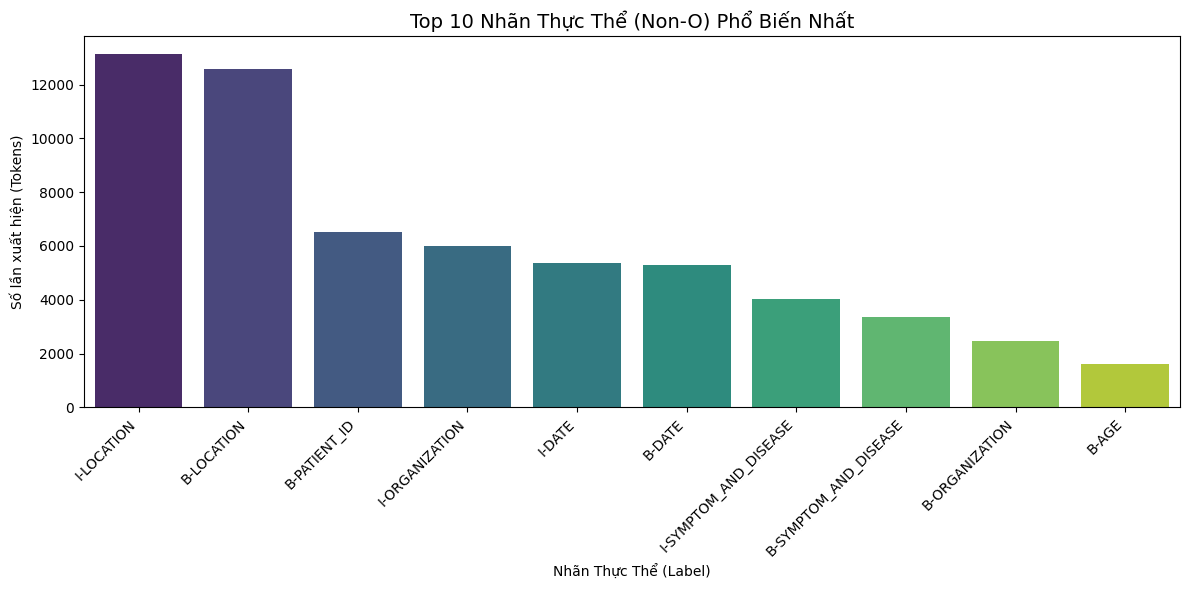


--- Phân Tích Mất Cân Bằng (O vs Non-O) ---
* Nhãn 'O' (Outside): 210,462 lần
* Tổng số Tokens mang nhãn Thực thể (non-O): 64,010 lần
* Tỷ lệ LỆCH (O / non-O): 3.29 lần


In [110]:
if not df_combined.empty:

    print(" 2. PHÂN BỐ NHÃN THỰC THỂ ")
 

    label_counts = df_combined['label'].value_counts()
    
    # Chỉ hiển thị các nhãn thực thể (non-O) phổ biến nhất
    entity_labels = label_counts[label_counts.index != 'O'].sort_values(ascending=False).head(10)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=entity_labels.index, y=entity_labels.values, palette="viridis")
    plt.title('Top 10 Nhãn Thực Thể (Non-O) Phổ Biến Nhất', fontsize=14)
    plt.xlabel('Nhãn Thực Thể (Label)')
    plt.ylabel('Số lần xuất hiện (Tokens)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # --- Phân Tích Mất Cân Bằng Nhãn (O vs Non-O) ---
    O_count = label_counts.get('O', 0)
    other_counts = label_counts[label_counts.index != 'O'].sum()

    print("\n--- Phân Tích Mất Cân Bằng (O vs Non-O) ---")
    if O_count > 0 and other_counts > 0:
        imbalance_ratio = O_count / other_counts
        print(f"* Nhãn 'O' (Outside): {O_count:,} lần")
        print(f"* Tổng số Tokens mang nhãn Thực thể (non-O): {other_counts:,} lần")
        print(f"* Tỷ lệ LỆCH (O / non-O): {imbalance_ratio:.2f} lần")


Nhãn xuất hiện nhiều nhất: F-location
Ít (hiếm nhất): B-age

3. PHÂN TÍCH ĐỘ DÀI CÂU (WORD-LEVEL)
--- Thống kê Độ dài Câu (Số lượng Words) ---
count    5,027.00
mean        26.36
std         12.50
min          6.00
25%         18.00
50%         24.00
75%         32.00
max        161.00
Name: sentence_len, dtype: object

* Percentile 90 (P90): 43 tokens
* Percentile 95 (P95): 50 tokens

💡 GỢI Ý MAX_LEN (nên dùng): **50** tokens (P95)


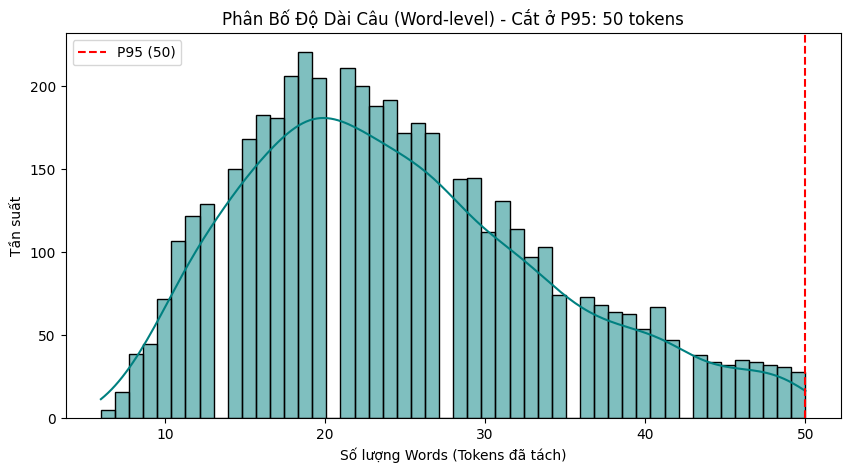

In [111]:
if not df_combined.empty:

    print("3. PHÂN TÍCH ĐỘ DÀI CÂU (WORD-LEVEL)")


    # Lấy độ dài câu duy nhất (số lượng Word)
    lengths_series = df_combined.drop_duplicates(subset='sentence_id')['sentence_len']

    # Thống kê chi tiết
    print("--- Thống kê Độ dài Câu (Số lượng Words) ---")
    print(lengths_series.describe().apply(lambda x: f'{x:,.2f}'))

    # Percentiles quan trọng
    p90 = lengths_series.quantile(0.90)
    p95 = lengths_series.quantile(0.95)

    suggested_max_len = int(p95)

    print(f"\n* Percentile 90 (P90): {p90:.0f} tokens")
    print(f"* Percentile 95 (P95): {p95:.0f} tokens")
    print(f"\n💡 GỢI Ý MAX_LEN (nên dùng): **{suggested_max_len}** tokens (P95)")

    # Vẽ Histogram (Chỉ trực quan hóa các câu <= P95)
    plt.figure(figsize=(10, 5))
    bins = min(50, int(lengths_series.max() - lengths_series.min()) if lengths_series.max() > lengths_series.min() else 1)
    sns.histplot(lengths_series[lengths_series <= suggested_max_len], bins=bins, kde=True, color='teal')
    plt.axvline(x=p95, color='red', linestyle='--', label=f'P95 ({p95:.0f})')
    plt.title(f'Phân Bố Độ Dài Câu (Word-level) - Cắt ở P95: {suggested_max_len} tokens')
    plt.xlabel('Số lượng Words (Tokens đã tách)')
    plt.ylabel('Tần suất')
    plt.legend()
    plt.show()

có những câu quá dài gây bất lợi cho LSTM 